# Data analysis
## Load from file

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# path directory in which the script is running
CURRENT_PATH = Path(os.path.abspath(""))
CURRENT_PATH = CURRENT_PATH.resolve()

FEATURE_PATH = CURRENT_PATH.parent.joinpath("data", "features", "motions")
AGGREGATED_DATA_PATH = FEATURE_PATH.joinpath("aggregated.csv")

if AGGREGATED_DATA_PATH.exists():
    data = pd.read_csv(AGGREGATED_DATA_PATH, header=0, index_col=False)
else:
    data = pd.DataFrame()
    for file in FEATURE_PATH.iterdir():
        name = file.name.split(".")[0]
        parts = name.split("_")
        method = ""
        if parts[-1] == "RAFT":
            method = "RAFT"
            parts.pop()
        else:
            method = "Farneback"
        session = parts[0]
        game = parts[2]
        position = "_".join(parts[3:])

        data_file = pd.read_csv(file, header=0, index_col=False)
        data_file["Method"] = method
        data_file["Session"] = session
        data_file["Game"] = game
        data_file["Position"] = position
        data = pd.concat([data, data_file], ignore_index=True, sort=False)

    data.to_csv(AGGREGATED_DATA_PATH, index=False)

data

,AVG_Optical_Flow,Timestamp,Method,Session,Game,Position
0,0.059038,0.000000,Farneback,SESS001,DESERT,bl
1,1.162210,0.399984,Farneback,SESS001,DESERT,bl
2,0.178124,0.799968,Farneback,SESS001,DESERT,bl
3,0.982264,1.199952,Farneback,SESS001,DESERT,bl
4,1.128049,1.599936,Farneback,SESS001,DESERT,bl
...,...,...,...,...,...,...
90013,0.561547,531.957443,RAFT,SESS009,JUNGLE,tr
90014,2.324876,532.357411,RAFT,SESS009,JUNGLE,tr
90015,0.904406,532.757379,RAFT,SESS009,JUNGLE,tr
90016,1.048347,533.157347,RAFT,SESS009,JUNGLE,tr


# Data analysis
## Differences between methods

In [2]:
farneback = data[data["Method"] == "Farneback"]
raft = data[data["Method"] == "RAFT"]

farneback = farneback.rename({"AVG_Optical_Flow": "Avg_Optical_Flow_Farneback"}, axis=1)
raft = raft.rename({"AVG_Optical_Flow": "Avg_Optical_Flow_RAFT"}, axis=1)

differences_methods = farneback.merge(
    raft,
    on=["Timestamp", "Session", "Game", "Position"],
    how="inner",
    validate="one_to_one",
)
differences_methods

,Avg_Optical_Flow_Farneback,Timestamp,Method_x,Session,Game,Position,Avg_Optical_Flow_RAFT,Method_y
0,0.059038,0.000000,Farneback,SESS001,DESERT,bl,0.027642,RAFT
1,1.162210,0.399984,Farneback,SESS001,DESERT,bl,1.230278,RAFT
2,0.178124,0.799968,Farneback,SESS001,DESERT,bl,0.105871,RAFT
3,0.982264,1.199952,Farneback,SESS001,DESERT,bl,1.059171,RAFT
4,1.128049,1.599936,Farneback,SESS001,DESERT,bl,1.281322,RAFT
...,...,...,...,...,...,...,...,...
45004,0.749167,531.957443,Farneback,SESS009,JUNGLE,tr,0.561547,RAFT
45005,1.980490,532.357411,Farneback,SESS009,JUNGLE,tr,2.324876,RAFT
45006,1.110894,532.757379,Farneback,SESS009,JUNGLE,tr,0.904406,RAFT
45007,1.017943,533.157347,Farneback,SESS009,JUNGLE,tr,1.048347,RAFT


       Avg_Optical_Flow_Farneback  Avg_Optical_Flow_RAFT          Diff
count                45009.000000           45009.000000  45009.000000
mean                     1.073743               1.705992     -0.632250
std                      1.320395               3.584303      2.787808
min                      0.000391               0.007830   -205.089825
25%                      0.223138               0.203377     -0.338656
50%                      0.558394               0.608765     -0.013730
75%                      1.387070               1.743762      0.045117
max                     15.276228             207.750090      5.920840


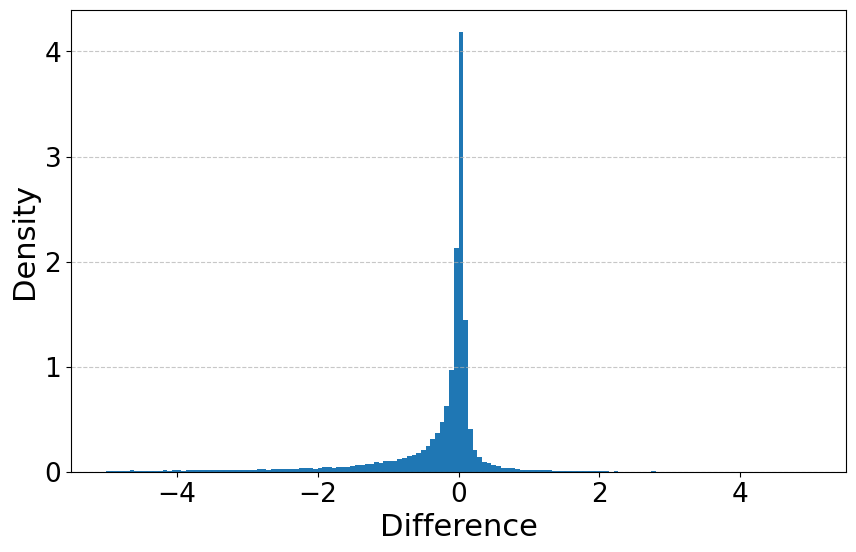

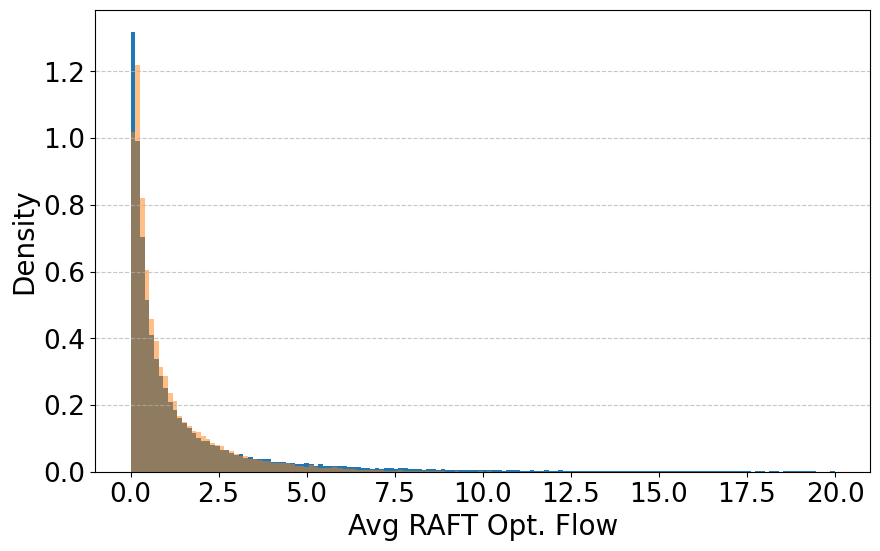

In [3]:
differences_methods["Diff"] = (
    differences_methods["Avg_Optical_Flow_Farneback"]
    - differences_methods["Avg_Optical_Flow_RAFT"]
)
print(
    differences_methods[
        ["Avg_Optical_Flow_Farneback", "Avg_Optical_Flow_RAFT", "Diff"]
    ].describe()
)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)
ax.hist(differences_methods["Diff"], bins=150, range=(-5, 5), density=True, log=False)
ax.set_xlabel("Difference", fontsize=22)
ax.set_ylabel("Density", fontsize=22)
ax.tick_params(axis="both", which="major", labelsize=19)
ax.tick_params(axis="both", which="minor", labelsize=19)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)
ax.hist(
    differences_methods["Avg_Optical_Flow_RAFT"],
    range=(0, 20),
    bins=150,
    density=True,
    log=False,
    label="RAFT",
)
ax.hist(
    differences_methods["Avg_Optical_Flow_Farneback"],
    range=(0, 20),
    bins=150,
    density=True,
    log=False,
    label="Farneback",
    alpha=0.5,
)
ax.set_xlabel("Avg RAFT Opt. Flow", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=19)
ax.tick_params(axis="both", which="minor", labelsize=19)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

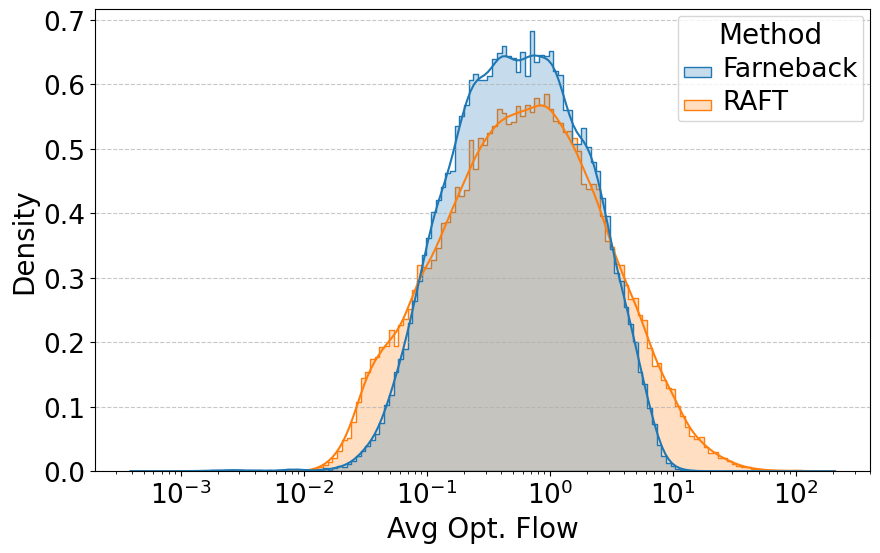

In [4]:
import seaborn as sns

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10, 6)
g = sns.histplot(
    data,
    x="AVG_Optical_Flow",
    hue="Method",
    stat="density",
    element="step",
    common_norm=False,
    kde=True,
    log_scale=True,
    ax=ax,
    legend=True,
)
ax.set_xlabel("Avg Opt. Flow", fontsize=20)
ax.set_ylabel("Density", fontsize=20)
ax.tick_params(axis="both", which="major", labelsize=19)
ax.tick_params(axis="both", which="minor", labelsize=19)
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.setp(ax.get_legend().get_texts(), fontsize="19")  # for legend text
plt.setp(ax.get_legend().get_title(), fontsize="20")  # for legend title
plt.show(g)

## Fitting Log-normal distributions
The average optical flow follows a distribution that seems to be log-normal for both methods.
In this section, we fit a normal distribution on the logarithm of the values and then compare the fitted normal distribution with the empirical distribution. The comparison is done with Kolmogorov-Smirnov test using the critical values for fitted distribution provided by the paper *A Note on the Possible Misuse of the Kolmogorov-Smirnov Test*.

The performance of the algorithms used to estimate optical flow degrade when the motion increases. So, it reasonable that for high values the  

Parameters fitted (-0.5987679246351214, 1.2228805565200274)
KS Test for Log-Norm: Statistic=0.0261, p-value=0.0000
Significance level 0.05. Reject H0 if 0.026145984726060556 > 0.004176226452442341


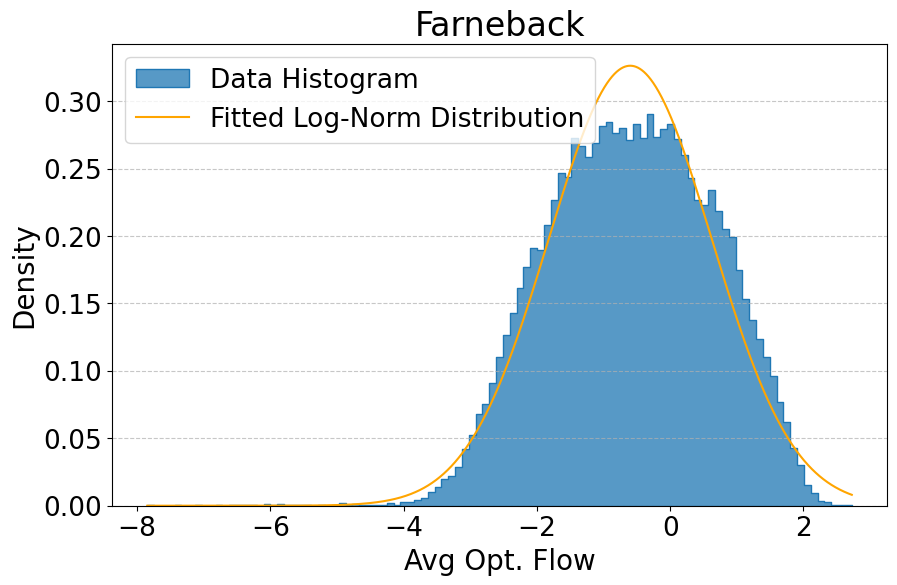

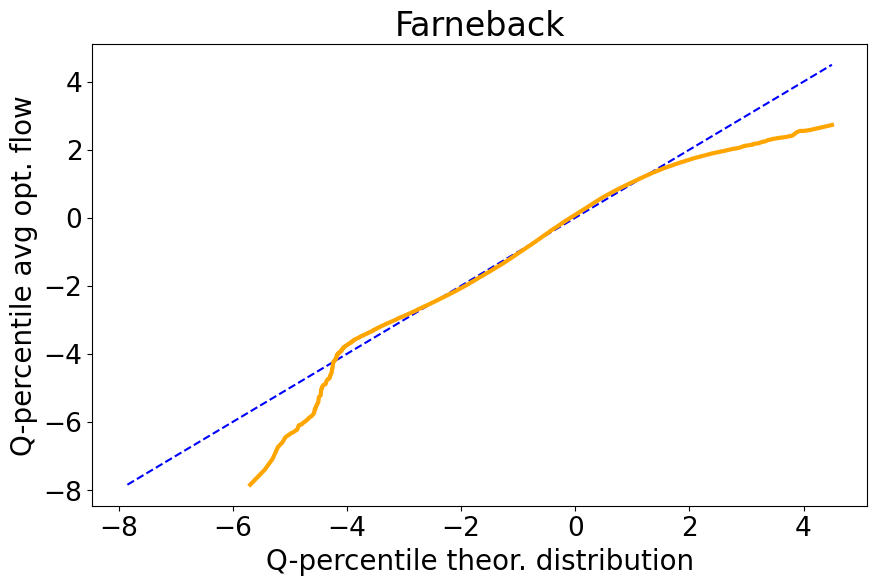

Parameters fitted (-0.5176792829632751, 1.4990800196423497)
KS Test for Log-Norm: Statistic=0.0163, p-value=0.0000
Significance level 0.05. Reject H0 if 0.01626162341827514 > 0.004176226452442341


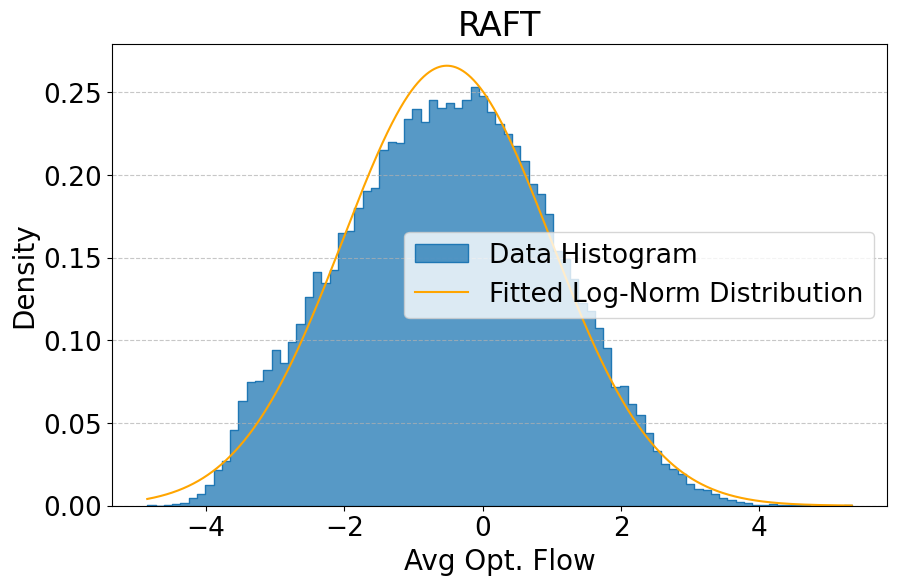

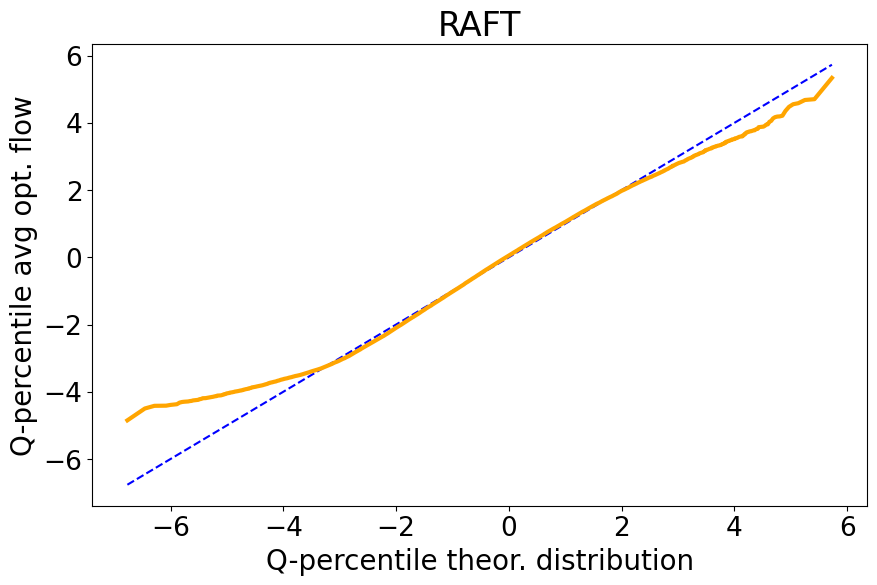

In [5]:
from math import exp, sqrt
import scipy.stats as stats

seed = 42
np.random.seed(seed)


def fit(optical_flow, distr, title, distr_label):
    # Fitted with MLE
    fit_params = distr.fit(optical_flow)
    print("Parameters fitted", fit_params)

    # Goodness of fit
    # Kolmogorov-Smirnov test for goodness of fit (compares )
    ks_res = stats.kstest(
        optical_flow, distr.cdf, alternative="two-sided", args=fit_params
    )  # not relevant the N parameter

    print(
        f"KS Test for {distr_label}: Statistic={ks_res.statistic:.4f}, p-value={ks_res.pvalue:.4f}"
    )
    print(
        f"Significance level 0.05. Reject H0 if {ks_res.statistic} > {0.886 * sqrt(1 / optical_flow.shape[0])}"
    )

    # Plot fitted and original distribution
    x = np.linspace(min(optical_flow), max(optical_flow), 10000)
    values_pdf = distr.pdf(x, *fit_params)

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 6)
    sns.histplot(
        optical_flow,
        stat="density",
        element="step",
        common_norm=False,
        kde=False,
        log_scale=False,
        ax=ax,
        legend=False,
        label="Data Histogram",
    )
    sns.lineplot(
        x=x,
        y=values_pdf,
        ax=ax,
        label=f"Fitted {distr_label} Distribution",
        legend=False,
        color="orange",
    )
    ax.set_xlabel("Avg Opt. Flow", fontsize=20)
    ax.set_ylabel("Density", fontsize=20)
    ax.set_title(title, fontsize=24)
    ax.tick_params(axis="both", which="major", labelsize=19)
    ax.tick_params(axis="both", which="minor", labelsize=19)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    plt.legend(fontsize=19)
    plt.show()

    # Q-Q plot
    qn_a, qn_b = stats.probplot(optical_flow, dist=distr, sparams=fit_params, fit=False)
    min_val = min(qn_a.min(), qn_b.min())
    max_val = max(qn_a.max(), qn_b.max())

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 6)
    sns.lineplot(
        x=[min_val, max_val],
        y=[min_val, max_val],
        dashes=True,
        markers=False,
        linestyle="dashed",
        color="b",
        alpha=1,
        ax=ax,
    )
    sns.lineplot(x=qn_a, y=qn_b, ax=ax, color="orange", alpha=1, linewidth=3)
    ax.set_ylabel("Q-percentile avg opt. flow", fontsize=20)
    ax.set_xlabel("Q-percentile theor. distribution", fontsize=20)
    ax.set_title(title, fontsize=24)
    ax.tick_params(axis="both", which="major", labelsize=19)
    ax.tick_params(axis="both", which="minor", labelsize=19)
    plt.show()


# Test data to check the algorithm
# print("Test values: (0, 1)")
# fit(
#     stats.norm.rvs(size=raft.shape[0]),
#     stats.norm,
#     title="Test",
#     distr_label="Norm",
# )

# The threshold for accepting the hypothesis is chosen for Normal distribution

# fit(
#     farneback["Avg_Optical_Flow_Farneback"],
#     stats.gamma,
#     title="Farneback",
#     distr_label="Gamma",
# )
# fit(raft["Avg_Optical_Flow_RAFT"], stats.gamma, title="RAFT", distr_label="Gamma")

# fit(
#     farneback["Avg_Optical_Flow_Farneback"],
#     stats.lognorm,
#     title="Farneback",
#     distr_label="Log-Norm",
# )
# fit(raft["Avg_Optical_Flow_RAFT"], stats.lognorm, title="RAFT", distr_label="Log-Norm")

fit(
    np.log(farneback["Avg_Optical_Flow_Farneback"]),
    stats.norm,
    title="Farneback",
    distr_label="Log-Norm",
)
fit(
    np.log(raft["Avg_Optical_Flow_RAFT"]),
    stats.norm,
    title="RAFT",
    distr_label="Log-Norm",
)

# Difference between people
The underlying assumption of this analysis is that different people move differently in a conversation.

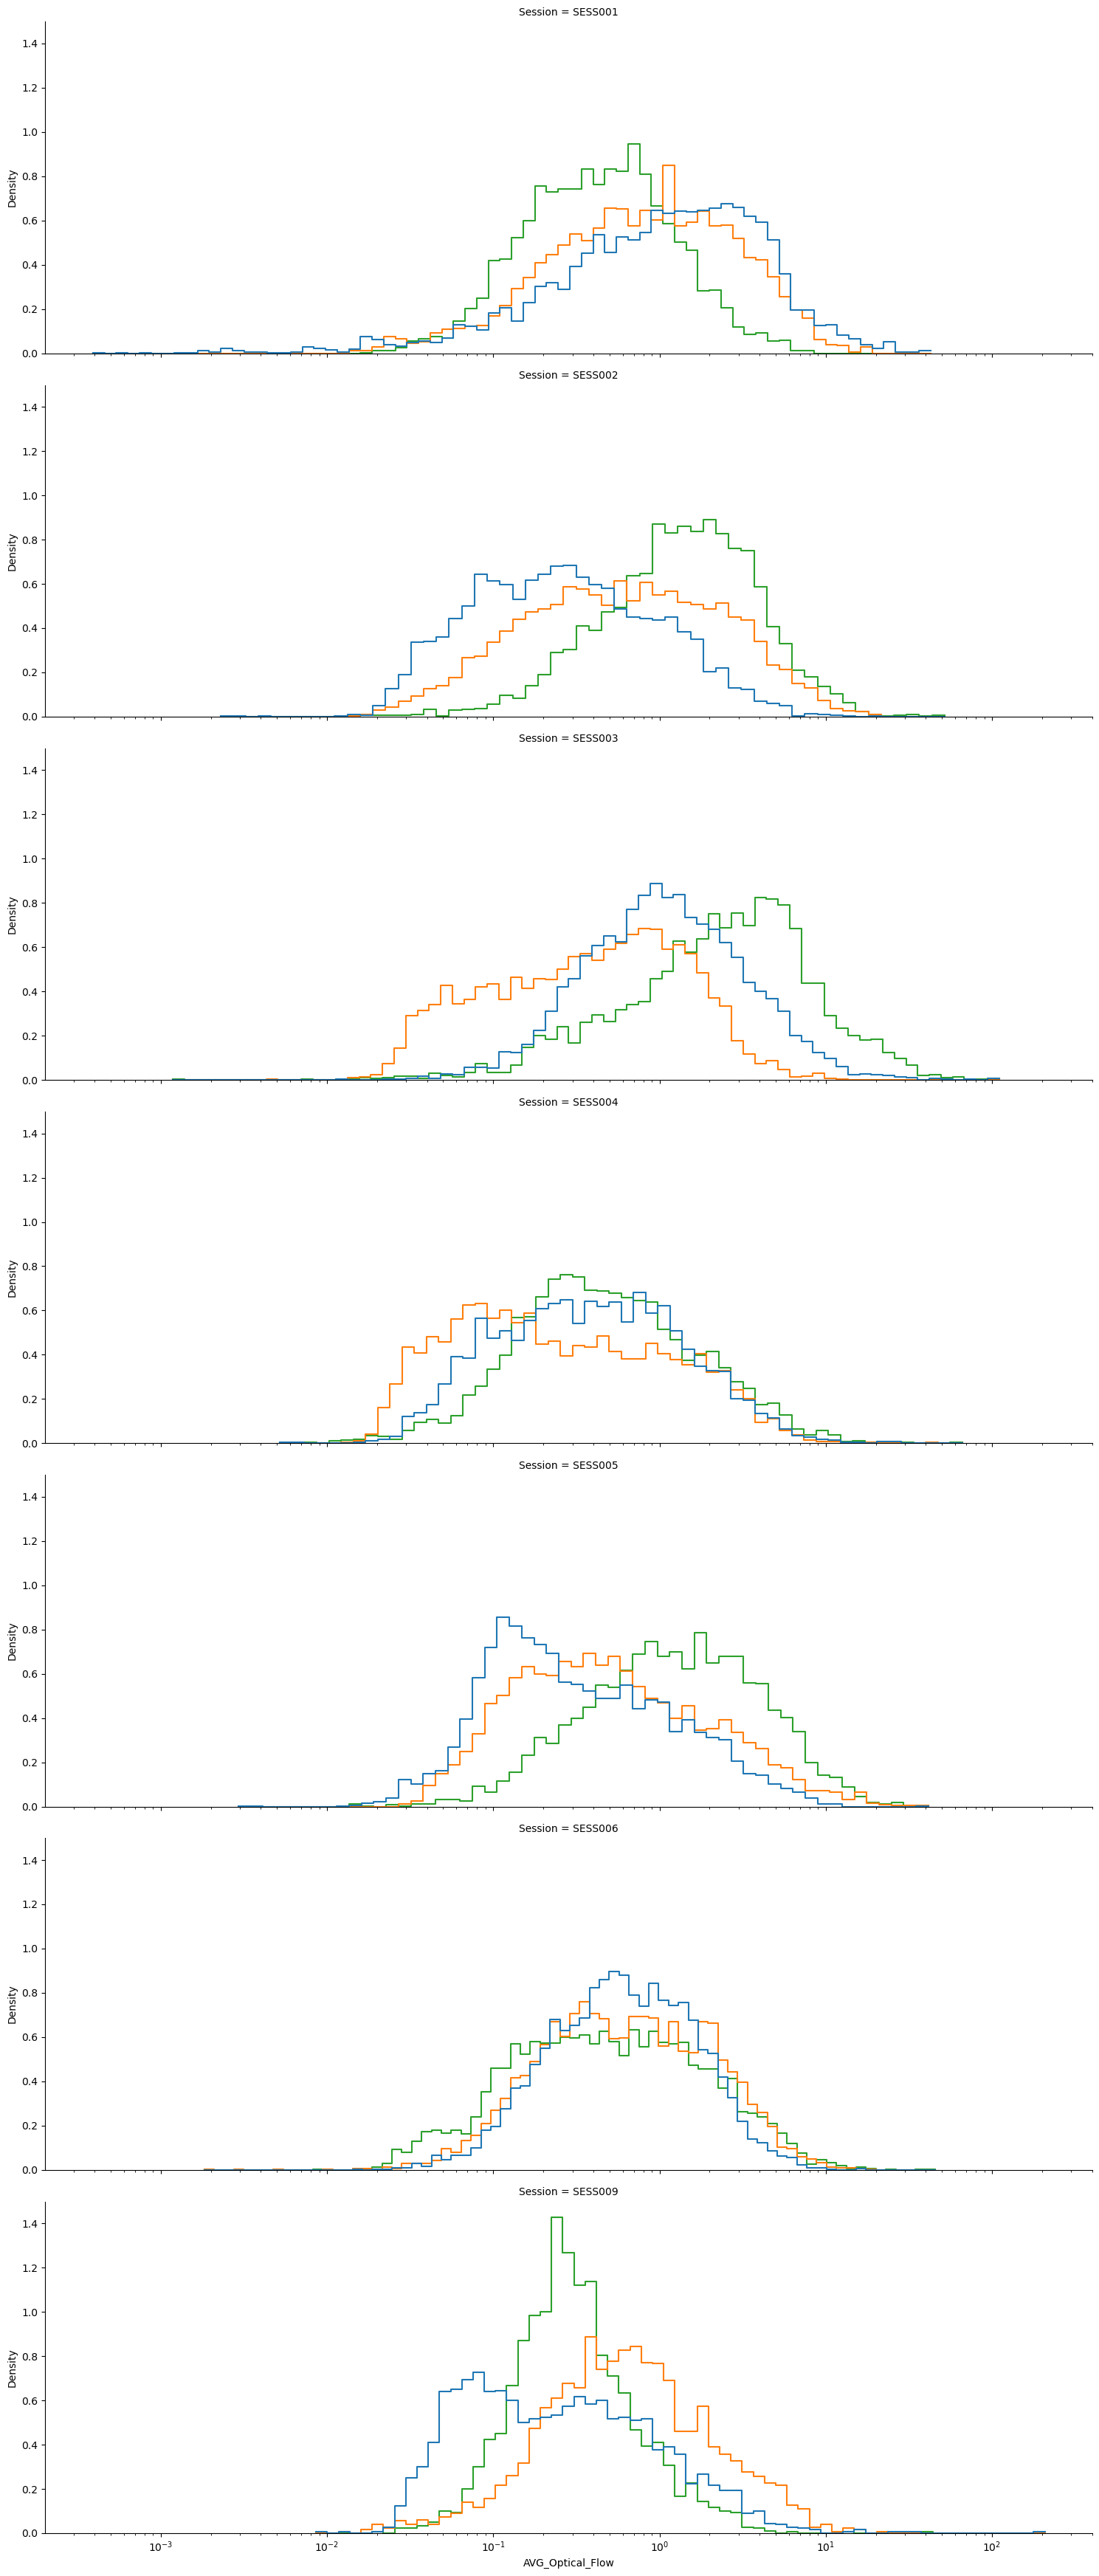

In [6]:
# session + position identifies the person
data["Person"] = data["Session"] + "_" + data["Position"]
data["Position"] = data["Position"].map(
    {"tl": "A", "tr": "B", "bl": "B", "br": "C", "bc": "C", "bl_tr": "B", "br_bc": "C"}
)

g = sns.FacetGrid(data, row="Session", height=5, aspect=3)
g.map_dataframe(
    sns.histplot,
    x="AVG_Optical_Flow",
    hue="Position",
    stat="density",
    element="step",
    common_norm=False,
    fill=False,
    log_scale=True,
)

## Person talking

Distribution of the motion for the person talking and for the people not talking.